In [3]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [11]:
class MAB(ABC):
    
    @abstractmethod
    def play(self, tround, context):
        # Current round of t (for my implementations average mean reward array 
        # at round t is passed to this function instead of tround itself)
        self.tround = tround
        # Context: features of contextual bandits
        self.context = context
        # choose an arm which yields maximum value of average mean reward, tie breaking randomly
        chosen_arm = np.random.choice(np.where(self.tround==max(self.tround))[0])
        return chosen_arm
        pass
        
    
    @abstractmethod
    def update(self, arm, reward, context):
        # get the chosen arm
        self.arm = arm
        # get the context (may be None)
        self.context = context
        # update the overall step of the model
        self.step_n += 1
        # update the step of individual arms
        self.step_arm[self.arm] += 1
        # update average mean reward of each arm
        self.AM_reward[self.arm] = ((self.step_arm[self.arm] - 1) / float(self.step_arm[self.arm]) 
        * self.AM_reward[self.arm] + (1 / float(self.step_arm[self.arm])) * reward)
        return
        pass


In [12]:
class EpsGreedy(MAB):
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # Set number of arms
        self.narms = narms
        # Exploration probability
        self.epsilon = epsilon
        # Q0 values
        self.Q0 = np.ones(self.narms)*np.inf
        # Total step count
        self.step_n = 0
        # Step count for each arm
        self.step_arm = np.zeros(self.narms)
        # Mean reward for each arm
        self.AM_reward = np.zeros(self.narms)
        super().__init__()
        return
        
    # Play one round and return the action (chosen arm)
    def play(self, tround, context=None):
        # Generate random number
        p = np.random.rand()
        
        if self.epsilon == 0 and self.step_n == 0:
            action = np.random.choice(self.narms)
        elif p < self.epsilon:
            action = np.random.choice(self.narms)
        else:
            # Q0 values are initially set to np.inf. Hence, choose an arm with maximum Q0 value (
            # for all of them is np.inf, and therefore will play all of the arms at least one time)

            if len(np.where(self.Q0==0)[0])<10:
                # choose an arm with maximum Q0 value
                action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
                # after the arm is chosen, set the corresponding Q0 value to zero
                self.Q0[action]=0
            else:
                # Now, after that we ensure that there is no np.inf in Q0 values and all of them are set to zero
                # we return to play based on average mean rewards
                action = super(EpsGreedy, self).play(self.AM_reward, context)
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1
    
        
    def update(self, arm, reward, context=None):
        super(EpsGreedy, self).update(arm, reward, context)
        return

In [13]:
class UCB(MAB):
    
    def __init__(self, narms, rho, Q0=np.inf):
        # Set number of arms
        self.narms = narms
        # Rho
        self.rho = rho
        # Q0 values
        self.Q0 = np.ones(self.narms)*np.inf
        # Total step count
        self.step_n = 0
        # Step count for each arm
        self.step_arm = np.zeros(self.narms)
        # Mean reward for each arm
        self.AM_reward = np.zeros(self.narms)
        super().__init__()
        return

    # Play one round and return the action (chosen arm)
    def play(self, tround, context=None):
        # Q0 values are initially set to np.inf. Hence, choose an arm with maximum Q0 value (
        # for all of them is np.inf, and therefore will play all of the arms at least one time)
            
        if len(np.where(self.Q0==0)[0])<10:
            # choose an arm with maximum Q0 value
            action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
            # after the arm is chosen, set the corresponding Q0 value to zero
            self.Q0[action]=0
        else:
            # Now, after that we ensure that there is no np.inf in Q0 values and all of them are set to zero
            # we return to play based on average mean rewards
            
            # construct UCB values which performs the sqrt part
            ucb_values = np.zeros(self.narms)
            for arm in range(self.narms):
                if self.step_arm[arm]>0:
                    ucb_values[arm]= np.sqrt(self.rho *(np.log(self.step_n)) / self.step_arm[arm])
            action = super(UCB, self).play(self.AM_reward + ucb_values, context)
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning     
        return action+1
        
        
    def update(self, arm, reward, context=None):
        super(UCB, self).update(arm, reward, context)
        return

In [14]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    # array to contain chosen arms in offline mode
    chosen_arms = np.zeros(nrounds)
    # rewards of each chosen arm
    reward_arms = np.zeros(nrounds)
    # cumulative reward at each iteration
    cumulative_reward = np.zeros(nrounds)
    # initialize tround to zero
    T = 0
    # initialize overall cumulative reward to zero
    G = 0
    # History or memory of offline evaluator
    history = []
    # play once and get the initial action
    action = mab.play(T, contexts[0,:])
    
    #===============================
    #    MAIN LOOP ...
    #===============================
    for i in range(np.shape(data)[0]):
        action = mab.play(T, contexts[i,:])
        if T<nrounds:
            # update parameters and play only when chosen arm from bandit matches data
            if action == arms[i]:
                # append the current context of chosen arm to the previous history (list)
                history.append(contexts[i,:])
                # get the reward of chosen arm at round T
                reward_arms[T] = rewards[i]
                # the returned action is between 1-10, setting to python encoding ==> 0-9
                mab.update(action-1, rewards[i], contexts[i,:])
                # update overall cumulative reward
                G += rewards[i]
                # update cumulative reward of round T 
                cumulative_reward[T] = G
                # store chosen arm at round T
                chosen_arms[T] = action
                T +=1
        else:
            # if desired tround ends, terminate the loop
            break
    return reward_arms, chosen_arms, cumulative_reward

In [15]:
data = np.loadtxt('./dataset.txt')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:102]
mab = EpsGreedy(10, 0.05)
results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.06125


In [16]:
mab = UCB(10, 1.0)
results_UCB, chosen_arms_UCB, cumulative_reward_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.13375


Plot of single simulation

EpsGreedy average reward 0.18625
UCB average reward 0.08


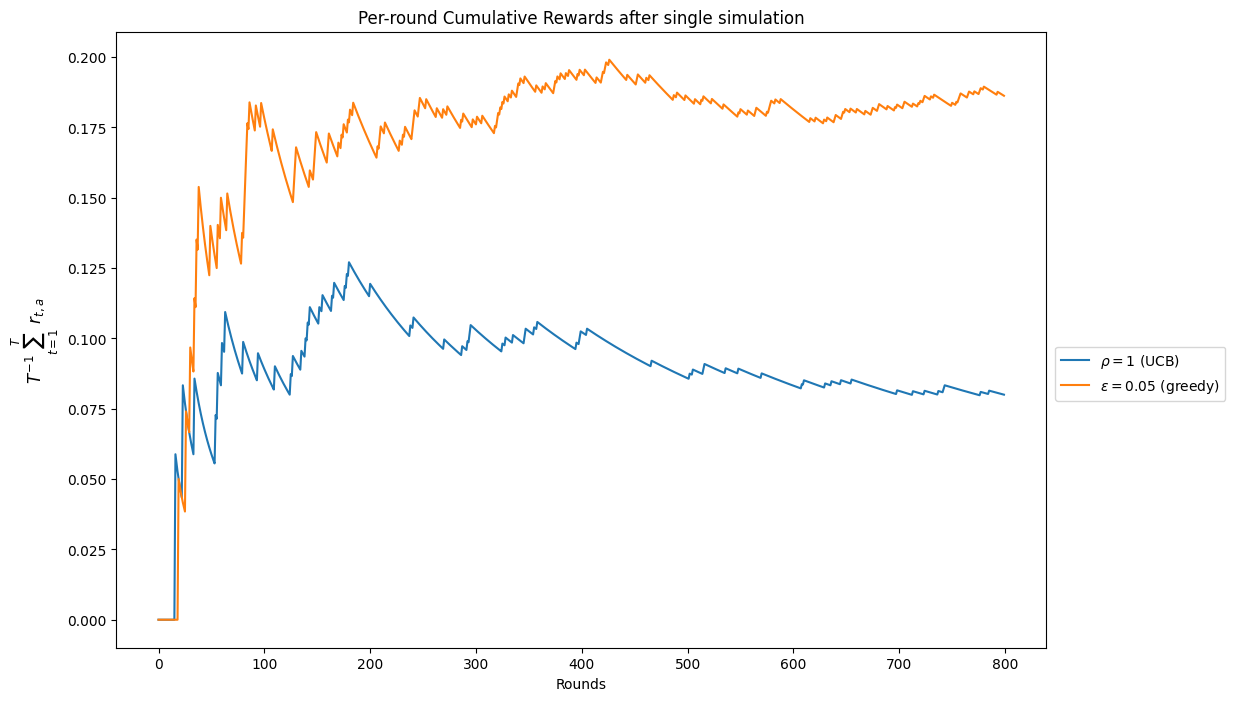

In [18]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))
mab = UCB(10, 1.0)
results_UCB, chosen_arms_UCB, cumulative_reward_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))
plt.figure(figsize=(12,8))
plt.plot(cumulative_reward_UCB/(np.linspace(1,800,800)), label = r"$\rho=1$ (UCB)")
plt.plot(cumulative_reward_EpsGreedy/(np.linspace(1,800,800)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after single simulation")
plt.show()

Plot of multiple simulations

EpsGreedy average reward 0.21782375
UCB average reward 0.179955


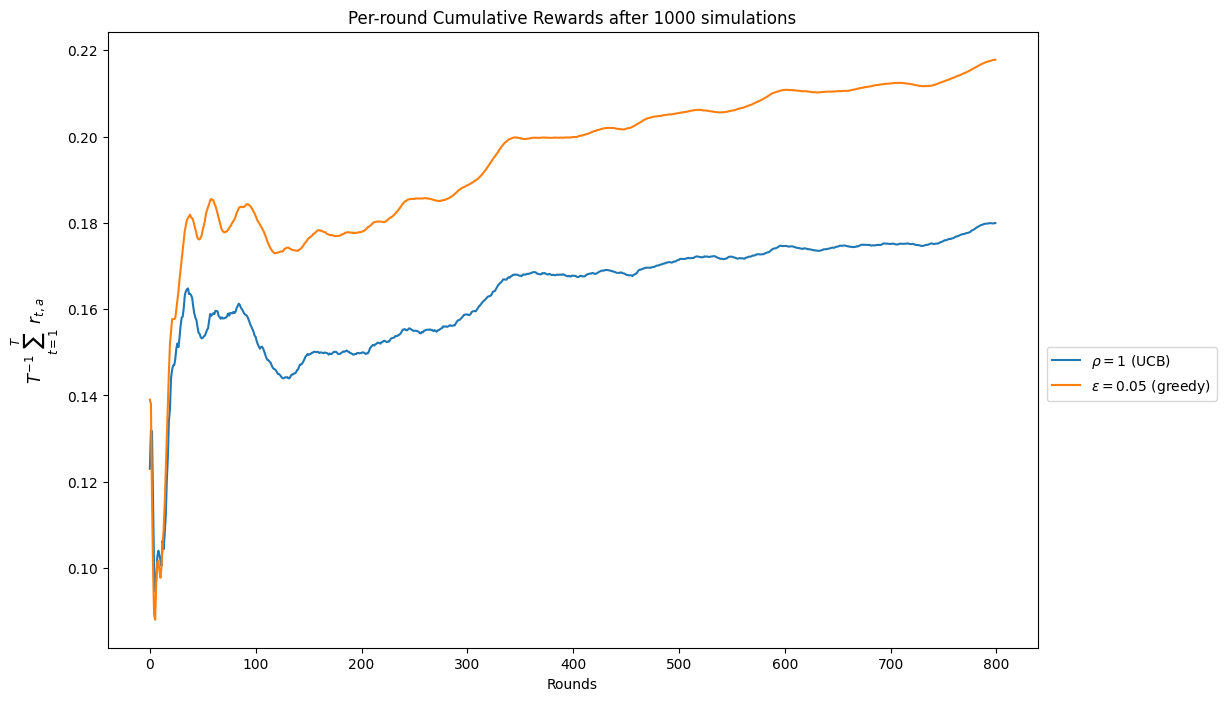

In [19]:
mean_EPSgreedy = np.zeros(800)
# aray to store average reward of each round for 1000 runs
average_results = np.zeros(800)
for i in range(1000):
    mab = EpsGreedy(10, 0.05)
    results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
    average_results += results_EpsGreedy
    mean_EPSgreedy += cumulative_reward_EpsGreedy
print('EpsGreedy average reward', np.mean(average_results/1000))
mean_UCB = np.zeros(800)
# aray to store average reward of each round for 1000 runs
average_results = np.zeros(800)
for i in range(1000):
    mab = UCB(10, 1.0)
    results_UCB, chosen_arms_UCB, cumulative_reward_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    average_results += results_UCB
    mean_UCB += cumulative_reward_UCB
print('UCB average reward', np.mean(average_results/1000))
plt.figure(figsize=(12,8))
plt.plot(mean_UCB/(1000*np.linspace(1,800,800)), label = r"$\rho=1$ (UCB)")
plt.plot(mean_EPSgreedy/(1000*np.linspace(1,800,800)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after 1000 simulations")
plt.show()